# Glider AZFP

<!-- ![./schematic.png](./schematic.png) -->
![./schematic.png](./schematic2.png)

This notebook attempts to outline the proceedure for loading an AZFP data file, loading the accompanying glider data (right now from ERDDAP) and applying the glider depth to the AZFP ranges (after the `echopype` processing steps).

It requires a work around involving the AZFP `.XML` calibration file: we have to use a 'fake' `.XML` where we must arbitrarily increase the temperature coefficents so that the temperature calculation in `echopype` doesn't fail and throw an error.

# to do
1. need the 'full-res' glider data. Hopefully soon we can get the delayed-mode data from ERDDAP, but also we could start doing this with the raw glider files
1. add the aligned depth bins to the calibrated dataset
1. add the lat / lon to the calibrated dataset
1. get a `distance` coordinate (in meters, will have the same dim of `time`)
1. Figure out if we need to correct for pitch and roll. check if pitch is too far off near the surface or bottom. there is a weird thing where the layers of high backscatter tend to look parrallel to the dive slope when the glider leaves the surface
1. remove any times when the glider is not pitched down at the right angle (sometimes the AZFP is sampling on the upcast, like in 19010219.01A)
1. check the settings (things like `absorption coefficient` (echopype: `ed.seawater_absorption`), `calibrationOffsetTS` and `twowaybeamangle` (echopype: `equivalent_beam_angle` that is used in the `Sv` calibration, but I can't see right now how its getting set) that are pointed out in Schyuler's presentation
1. remove the first few obviously bad range bins
1. detect and mask the bottom
1. apply depth-corrected MVBS
1. apply swarm detection algos

In [1]:
from echopype.convert import Convert
from echopype import Process

import numpy as np
from erddapy import ERDDAP
import pandas as pd
import glob
import random

import xarray as xr

import matplotlib.pyplot as plt

# load in the glider data

For now use `erddapy` to get the glider data. maybe this will always be good (though we want to get the delayed mode, not real time data at some point). Otherwise we may switch to reading the raw glider data files with `dbdreader` at some point. But for now this is fine.

This should be done outside any processing loop - it only needs to be done once

In [2]:
# sets up the connection to the data
e = ERDDAP(
server="http://slocum-data.marine.rutgers.edu/erddap",
protocol="tabledap",
response="nc",
)

#two different deployements
# dataID_ross = 'ru32-20180109T0531-profile-sci-delayed'
dataID_palmer = 'ru32-20190102T1317-profile-sci-rt' # this is what we should use

# get the science data:
e.dataset_id = dataID_palmer

# this connects to the data and load into an xarray dataset

ru32 = e.to_xarray()

# want to have the dimention be time not obs number

ru32 = ru32.swap_dims({"obs": "time"})
ru32 = ru32.sortby("time")


# ru32.load()


# pick an AZFP file to work on

Later, this all should go in a loop, or get a big procced file

In [3]:
# identify a file you want
# fname = '19011711' # sees  the bottom
# fname = '19010212' # I think this is before the glider was put in water
# fname = '19011717'


path_to_raw = './data/'

# alternativly, pick a random file
all_files = glob.glob(path_to_raw+'*.01A')
# a random file from the list (got to remove path and extention)
fname = random.choice(all_files)[7:-4]

# path to the 'fake' calibration file
calib_file = './data/NLB_test.XML'

print('random file used:')
print(fname + '.01A')

random file used:
19010219.01A


# read in AZFP

do the whole workflow here from the raw `*.01A` data through the procced results

need also to investigate the instrument angle. This could be in `ed.tilt_angle` (or in `ed.equivalent_beam_angle` this is EK60 only?? not sure how it is getting set for the AZFP)

check out `ed.tilt_angle` in https://github.com/OSOceanAcoustics/echopype/blob/master/echopype/process/azfp.py

need to set the `ed.tilt_angle` manually i think

though looking at the glider pitch, its pretty close to the set angle of the azfp

In [4]:

# converts the raw AZFP data
# we are 'tricking' echopype with a fake .XML file
# the real files fail because there is no temperature data
# edit the './data/' parts so the path works for where you put the files
data_tmp = Convert(path_to_raw + fname + '.01A', calib_file)


# place to save processed files
savedir = './data_netcdfs/'

# converts to a netcdf we can use with xarray
data_tmp.raw2nc(save_path = savedir )


# read the converted data 

nc_path = savedir + fname + '.nc'

# process so you can get calibrated, clean, data 

ed = Process(nc_path)   # create a processing object

# need to figure out how much it matter that these vary a lot
ed.temperature = 0.5   # temperature in degree Celsius
ed.salinity = 34     # salinity in PSU
ed.pressure = 50     # pressure in dbar
ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv
ed.remove_noise()        # denoise, this is adaptive! will change with the file!
ed.get_MVBS()  

# look at what is in the cleaned 
# signal backscatter strenght dataset
ed.Sv_clean


10:41:05 converting file 19010219.01A with NLB_test.XML, time of first ping 2019-Jan-02 19:10:48
          ... this file has already been converted to .nc, conversion not executed.
Initialize using average temperature recorded by instrument
10:41:06  calibrating data in ./data_netcdfs/19010219.nc
10:41:06  Remove noise from Sv stored in memory.
10:41:07  use Sv stored in memory to calculate MVBS


<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 984, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-02T19:10:48 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 -98.3...
    noise_est_range_bin_size  (frequency) float64 5.005 5.005 5.005
    range                     (frequency, range_bin) float64 0.3627 ... 72.83
Attributes:
    noise_est_ping_size:  30

<ipython-input-5-efe460e8ec6e>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh( ed.Sv_clean.ping_time, ed.Sv_clean.range_bin,


Text(0.5, 0, 'time')

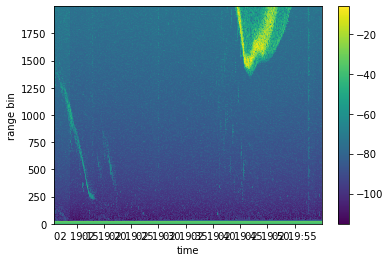

In [5]:
# make a simple plot of some of the AZFP echo data
# you need to 'flip' or transpose the data so the dims match the shape of the backscatter data
# just plot one frequency:

plt.pcolormesh( ed.Sv_clean.ping_time, ed.Sv_clean.range_bin, 
               ed.Sv_clean.Sv.sel(frequency = ed.Sv_clean.frequency[2]).T )

plt.colorbar()

plt.ylabel('range bin')
plt.xlabel('time')

# get a subset of the glider data 
that corresponds to the section of AZFP data we have

2019-01-02T19:10:48.000000000
2019-01-02T19:59:57.000000000


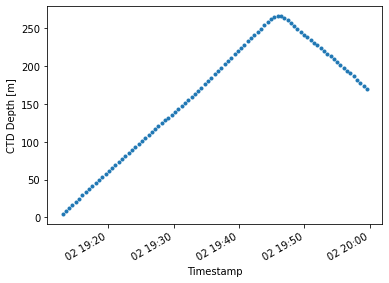

In [6]:
start_time = ed.Sv_clean.ping_time[0]
end_time = ed.Sv_clean.ping_time[-1] 


segment_ru32 = ru32.sel( time = slice(start_time,end_time) )

print(start_time.values)
print(end_time.values)

segment_ru32.depth.plot(marker='.', ls='')

# glider pitch and roll

azfp is mounted at 22.5 deg

check out how much the glider is moving. native units are radians

how much do we need to feed this into the echopype processing to align the bins in depth?

Text(0, 0.5, 'pitch [deg]')

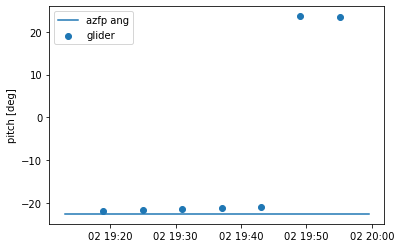

In [7]:
# segment_ru32.m_pitch.plot(marker='.', ls='')
plt.scatter(segment_ru32.time, segment_ru32.m_pitch*180/np.pi, label='glider')
plt.plot(segment_ru32.time[[0,-1]], [-22.5,-22.5], label='azfp ang')
plt.legend()
plt.ylabel('pitch [deg]')



# plt.figure()
# try:
#     plt.scatter(segment_ru32.time, segment_ru32.m_roll*180/np.pi,)
#     plt.ylabel('m-roll [deg]')
# except:
#     print('no roll data for some reason')

# get glider data onto AZFP time

There are NaNs in the glider data that need to be taken care of. 

also at least in the real-time ERDDAP data there are duplicate time stamps that need to be removed. Try resampling to get rid of this

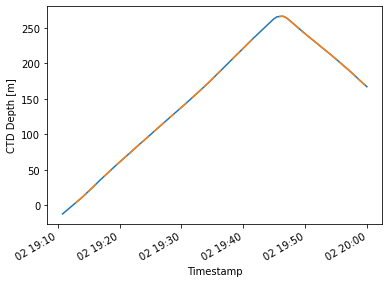

In [9]:

# list the variables we want to keep
varz = ['potential_temperature', 'salinity', 
        'chlorophyll_a','m_pitch',
       'm_roll', ]

# just get some variables
# also, make the lat, lon, depth into variables for interpolation:
glider_var_subset = segment_ru32[varz].reset_coords()

segment_ru32nafill = glider_var_subset.interpolate_na(dim='time')
glider_interp = segment_ru32nafill.interp( time = ed.Sv_clean.ping_time.data,
                                         kwargs={"fill_value": "extrapolate"})



glider_interp.depth.plot()
segment_ru32.depth.plot()

In [ ]:
# do some data cleaning of the glider depth data
# need to do a few steps to get the depth info
# onto the same times as the AZFP data

depth = segment_ru32.depth

# resample, for some reason there are non unique times
depth = depth.resample(time="5s").mean()
# interpolate the nans
depth = depth.interpolate_na(dim='time')


# interpolate onto the AZFP times,
# need to remove all nan's
# not sure why but the extrapolation isn't working
depi = depth.interp( time = ed.Sv_clean.ping_time.data,).ffill(dim='time').bfill(dim='time')

In [ ]:
depth.plot(marker='.', ls='')
depi.plot(marker='.', ls='')

# convert azfp ranges to depths

The corrected bin depths should be saved into the netcdf

In [ ]:
# pick one frequency
freqs = ed.Sv_clean.frequency.data
freq = freqs[1]

# get the range bins for this frequency
ranges = ed.Sv_clean.range.sel(frequency = freq )

# stack copies of the depth data so that it has 
# a shape that is rangebins x time
RR = np.tile(ranges.T, (len(depi),1))

# locate each bin in depth by adding the range of that bin
# to the concurrent glider depth at that time
bin_depths = RR.T+ depi.T.data

# bin_depths should be added to the dataset

# for plotting we need a stacked copy of the times with 
# the same shape as the adjusted depth-bins
TT = np.tile(ed.Sv_clean.ping_time, (len(ranges), 1))



In [ ]:

# test plotting
# looks whacky, but I think pcolor is connecting the subsequent downcasts
# if you have more than one profile

plt.figure(figsize=(8,8))
plt.pcolormesh( TT, bin_depths, 
               ed.Sv_clean.Sv.sel(frequency =freq).T,
              )
depth.plot()
plt.colorbar()



plt.plot(depth.time, depth)
segment_ru32.depth.plot(marker='.', ls='')
# plt.xlim(['2019-01-17 17:30', '2019-01-17 17:35'])
plt.ylim([bin_depths.max(), 0])
plt.ylabel('depth')

plt.figure(figsize=(8,8))

plt.pcolormesh( ed.Sv_clean.ping_time, ranges, 
               ed.Sv_clean.Sv.sel(frequency =freq).T )
plt.ylabel('Range')
plt.ylim([ranges.max(), 0])

plt.colorbar()

# plt.xlim(['2019-01-17 12:15', '2019-01-17 13:00'])

# plot one ping

let's just look at a few pings as a line plot to get a look at the structure:.

can see the first few bad bins easily, then a systematic rolloff. the systematic structure comes from the calibration wich has a log10(range) in it (https://support.echoview.com/WebHelp/Reference/Algorithms/Echosounder/ASL/AZFP_Sv_and_TS.htm)

In [ ]:

mid_ind = round(len(ed.Sv_clean.ping_time)/2)


# some points from the middle 
profs = ed.Sv_clean.Sv.sel(frequency
                           =freq)[mid_ind:mid_ind+5,:].data

# some points from the start:
profs = ed.Sv_clean.Sv.sel(frequency
                           =freq)[:5,:].data
plt.plot(profs.T);
plt.ylabel('Sv [dbar]')
plt.xlabel('range bin number')


# this is part of the basic calibration 
# it's dependant on the log of the range
plt.figure()
plt.plot(np.log10(ed.Sv_clean.range.T));

# MVBS
This you need to think about. echopype is doing some stuff, including averaging in range bins. but your range bins are not at a fixed depth, so probably this is not good. it will need to be done respecting the profiling, like the adcp binning

it seems like MVBS is just taking a mean (of the linear proccessed Sv), so you can do this youreself in the correct depth bins. 